# Looking for a fast Neighbour Search for MDAnalysis

This notebook is written to compare a few implementations of neighbour search.
The following implementations are compared:

- MDAnalysis Periodic KDTree (from ``MDAnalysis.lib.KDTree``)
- Biopython KDTree (see [here](http://biopython.org/DIST/docs/api/Bio.KDTree-module.html))
- Scipy cKDTree (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html))
- the neighbour search routine from [FATSLiM](http://fatslim.github.io/) which is Cython extension heavily based on the grid NS routine from [GROMACS](http://www.gromacs.org/)

The first three were already tested and benchmarked by [Ayush](https://github.com/ayushsuhane) (see [here](https://github.com/ayushsuhane/Benchmarks_Distance)) and [Jonathan](https://github.com/jbarnoud) (see [here](https://github.com/jbarnoud/Benchmarks_Distance/blob/test-scipy/Notebooks/Octree.ipynb)). So the goal of this notebook is just to compared to Cython-based NS routine.

This Cython routine is avaible [here](./core_ns.pyx) and can be compiled using the following [setup.py](./setup.py).


## Useful Setup
This is just the usual python imports and some helpful functions... nothing fancy here, you can skip this part.

In [1]:
import numpy as np
from collections import defaultdict
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 96


In [2]:
def load_results(filename):
    results_dict = defaultdict()
    results = np.load(filename)
    
    for name in results.files:
        results_dict[name] = results[name]
    
    return results_dict

# PBC-awareness check

In [3]:
# Load test data
coords = np.loadtxt("benchmark_input_1000.txt").astype(np.float32)
box = np.array([100.,100.,100.,90,90,90],dtype=np.float32)
triclinic_box = np.array([[100.0, 0, 0],[0, 100.0, 0],[0,0,100.0]], dtype=np.float32)
cutoff = 10

Note that we use a position close to the origin to make sure that it will have neighbours among the PBC-images:

In [4]:
pos = np.array([1,1,1], dtype=np.float32)
pos

array([1., 1., 1.], dtype=float32)

First we used the Periodic KDTree from MDAnalysis as a reference:

In [5]:
from MDAnalysis.lib.pkdtree import PeriodicKDTree

pkdt = PeriodicKDTree(box,bucket_size=10)
pkdt.set_coords(coords)
pkdt.search(pos,cutoff)
results_pkdtree = coords[pkdt.get_indices()]

results_pkdtree = results_pkdtree[np.argsort(results_pkdtree[:,0])]
print(results_pkdtree)

[[ 0.8409366  5.9870667 94.13265  ]
 [ 1.5735979  2.3142874 91.23573  ]
 [ 6.709149   5.9509816  2.8528259]
 [ 8.388782   3.3993251 96.91602  ]
 [96.08428   99.03588    1.4533074]
 [96.42065    8.109384   2.3468683]]


/Users/sbuchoux/anaconda3/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


Now, we can compare with cKDTree which, unfortunately does not handle PBC:

In [6]:
import scipy.spatial as ss

ckdtree = ss.cKDTree(coords)
results_ckdtree = coords[ckdtree.query_ball_point(pos, cutoff)]

results_ckdtree = results_ckdtree[np.argsort(results_ckdtree[:,0])]
print(results_ckdtree)

[[6.709149  5.9509816 2.8528259]]


And finally, the Cython NS routine which supports PBC:

In [7]:
from core_ns import FastNS

searcher = FastNS(triclinic_box)
searcher.set_cutoff(cutoff)
searcher.set_coords(coords)
searcher.prepare()

results_cython = searcher.search(np.array([pos,]))[0]

results_cython = results_cython[np.argsort(results_cython[:,0])]
print(results_cython)

[[ 0.8409366  5.9870667 94.13265  ]
 [ 1.5735979  2.3142874 91.23573  ]
 [ 6.709149   5.9509816  2.8528259]
 [ 8.388782   3.3993251 96.91602  ]
 [96.08428   99.03588    1.4533074]
 [96.42065    8.109384   2.3468683]]


# Benchmark - Intro

All benchmarks data were obtained using the following script: [run_benchmarks.py](./run_benchmarks.py). Just run the script to run the benchmarks again (and overrides the following results).
Please note that for reproductibility, all input data are available in `benchmark_input_[size].txt` and loaded by the benchmark script.
This notebook only loads benchmark results from the associated `benchmark-[type]_[algo].npz`.

# Benchmark - Single query

First, benchmark using one query (ie get neighbors for one single position)

Results for single query benchmark (10 repeats of 100 loops):


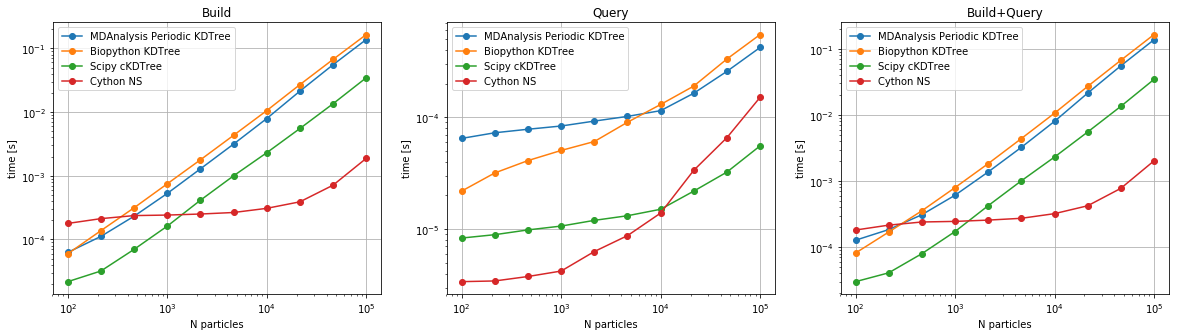

In [8]:
BENCHMARKS = [
    ("MDAnalysis Periodic KDTree", "mdakdtree"),
    ("Biopython KDTree", "biokdtree"),
    ("Scipy cKDTree", "ckdtree"),
    ("Cython NS", "cython")
]

fig, axes = plt.subplots(ncols=3, figsize=(20,5))

for name, filename in BENCHMARKS:
    results = load_results("benchmark-single_{}.npz".format(filename))
    
    axes[0].plot(results["nparticles"], results["build"].min(axis=1), 'o-', label=name)
    
    axes[1].plot(results["nparticles"], results["query"].min(axis=1), 'o-', label=name)
    
    axes[2].plot(results["nparticles"], results["build"].min(axis=1) + results["query"].min(axis=1), 'o-', label=name)

for i, name in enumerate(["Build", "Query", "Build+Query"]):
    axes[i].set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title=name)
    
for ax in axes:
    ax.legend()
    ax.grid(True)
    
print("Results for single query benchmark ({} repeats of {} loops):".format(*results["params"]))
plt.show()

## Multiple queries

Next, benchmark using several queries. Only cKDTree and Cython routine were tested here as they are the fastest.

Results for multiple query benchmark (10 repeats of 100 loops - 10000 coordinates):


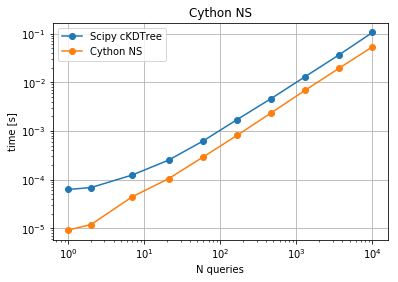

In [9]:
BENCHMARKS = [
    ("Scipy cKDTree", "ckdtree"),
    ("Cython NS", "cython")
]

fig, axes = plt.subplots(ncols=1)

for name, filename in BENCHMARKS:
    results = load_results("benchmark-multiple_{}.npz".format(filename))
        
    axes.plot(results["nqueries"], results["query"].min(axis=1), 'o-', label=name)
    
axes.set(xlabel='N queries', ylabel='time [s]', xscale='log', yscale='log', title=name)
axes.legend()
axes.grid(True)

print("Results for multiple query benchmark ({} repeats of {} loops - {} coordinates):".format(*results["params"]))
plt.show()

## Parallelism

Techically, the Cython NS routine is parallelized... Yet, the parellization is partial and probably not that great given the poor scaling:

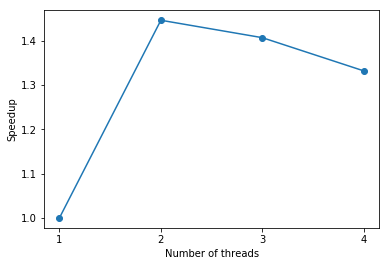

In [10]:
results = load_results("benchmark-parallelism_cython.npz")

times = 1/results["query"].min(axis=1)
times /= times[0]
plt.plot(results["nthreads"], times, "-o")

axes = plt.gca()

axes.set(
    xticks=results["nthreads"],
    xlabel="Number of threads",
    ylabel="Speedup"
)

plt.show()